In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pest-dataset/pest/test/beetle/jpg_9.jpg
/kaggle/input/pest-dataset/pest/test/beetle/jpg_18.jpg
/kaggle/input/pest-dataset/pest/test/beetle/jpg_33.jpg
/kaggle/input/pest-dataset/pest/test/beetle/jpg_54.jpg
/kaggle/input/pest-dataset/pest/test/beetle/jpg_22.jpg
/kaggle/input/pest-dataset/pest/test/beetle/jpg_35.jpg
/kaggle/input/pest-dataset/pest/test/beetle/jpg_10.jpg
/kaggle/input/pest-dataset/pest/test/beetle/jpg_39.jpg
/kaggle/input/pest-dataset/pest/test/beetle/jpg_29.jpg
/kaggle/input/pest-dataset/pest/test/beetle/jpg_15.jpg
/kaggle/input/pest-dataset/pest/test/beetle/jpg_30.jpg
/kaggle/input/pest-dataset/pest/test/beetle/jpg_3.jpg
/kaggle/input/pest-dataset/pest/test/beetle/jpg_52.jpg
/kaggle/input/pest-dataset/pest/test/beetle/jpg_20.jpg
/kaggle/input/pest-dataset/pest/test/beetle/jpg_20 - Copy.jpg
/kaggle/input/pest-dataset/pest/test/beetle/jpg_51.jpg
/kaggle/input/pest-dataset/pest/test/beetle/jpg_17.jpg
/kaggle/input/pest-dataset/pest/test/beetle/jpg_53.jpg
/kagg

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau , ModelCheckpoint
from keras.applications.mobilenet import MobileNet ,preprocess_input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


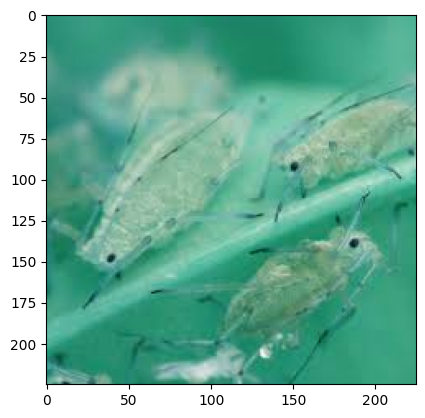

In [3]:
img=cv2.imread('../input/pest-dataset/pest/train/aphids/jpg_0 - Copy (2).jpg')
plt.imshow(img)
plt.show()

In [4]:
img=np.array(img)
img.shape

(225, 225, 3)

In [5]:
train_dir='../input/pest-dataset/pest/train/'
test_dir='../input/pest-dataset/pest/test/'



training=tf.keras.preprocessing.image.ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(train_dir,batch_size=16,target_size=(224,224),subset="training")

validing=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(train_dir,batch_size=16,target_size=(224,224),subset='validation',shuffle=True)

testing=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
).flow_from_directory(test_dir,batch_size=16,target_size=(224,224),shuffle=True)

Found 2565 images belonging to 9 classes.
Found 135 images belonging to 9 classes.
Found 450 images belonging to 9 classes.


In [6]:
mobilenet=MobileNet(include_top=False,weights='imagenet',input_shape=(224,224,3))

17225924/17225924 [==============================] - 0s 0us/step


In [7]:
optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.99)

/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_acc',verbose=2,factor=0.5,min_lr=0.00001)
callback=[EarlyStop , Reduce_LR]
#model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
#callback=[EarlyStop , Reduce_LR,model_check]

In [9]:
mobilenet.trainable=False

In [10]:
model=Sequential([
    mobilenet,
    MaxPooling2D(3,2),
    Flatten(),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dense(1024,activation='relu'),
    BatchNormalization(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dense(9,activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 1024)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                        

In [12]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=["accuracy"])

In [13]:
history=model.fit(training,validation_data=validing,epochs=20,batch_size=16,
                  steps_per_epoch=len(training) // 16,validation_steps=len(validing) // 8,
                  callbacks=callback, verbose=2)

Epoch 1/20
10/10 - 10s - loss: 2.5463 - accuracy: 0.2688 - val_loss: 9.7717 - val_accuracy: 0.1250 - lr: 0.0010 - 10s/epoch - 1s/step
Epoch 2/20
10/10 - 6s - loss: 2.0132 - accuracy: 0.5250 - val_loss: 5.9015 - val_accuracy: 0.3125 - lr: 0.0010 - 6s/epoch - 642ms/step
Epoch 3/20
10/10 - 6s - loss: 1.5091 - accuracy: 0.5750 - val_loss: 5.5039 - val_accuracy: 0.3125 - lr: 0.0010 - 6s/epoch - 626ms/step
Epoch 4/20
10/10 - 6s - loss: 1.3236 - accuracy: 0.6187 - val_loss: 11.5212 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 6s/epoch - 626ms/step
Epoch 5/20
10/10 - 7s - loss: 0.9237 - accuracy: 0.7125 - val_loss: 4.6397 - val_accuracy: 0.3125 - lr: 0.0010 - 7s/epoch - 703ms/step
Epoch 6/20
10/10 - 6s - loss: 1.1077 - accuracy: 0.6313 - val_loss: 1.6839 - val_accuracy: 0.5000 - lr: 0.0010 - 6s/epoch - 631ms/step
Epoch 7/20
10/10 - 7s - loss: 0.9396 - accuracy: 0.7250 - val_loss: 2.1614 - val_accuracy: 0.4375 - lr: 0.0010 - 7s/epoch - 684ms/step
Epoch 8/20
10/10 - 6s - loss: 1.0072 - accuracy: 0.

In [14]:
model.save('/kaggle/working/output/my_model.h5')

In [19]:
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

In [20]:
model = load_model('/kaggle/working/output/my_model.h5')

In [21]:
img_path = '../input/pest-dataset/pest/train/aphids/jpg_0 - Copy (2).jpg'
img = image.load_img(img_path, target_size=(224, 224)) # Resize the image to match the input size of the model
img_array = image.img_to_array(img) # Convert the image to an array
img_array = np.expand_dims(img_array, axis=0) # Add a batch dimension

# Pass the image through the model and get the predictions
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)

1/1 [==============================] - 1s 693ms/step


In [22]:
print("Predicted class:", predicted_class)

Predicted class: 5
